In [2]:
import numpy as np
import nnfs
from nnfs.datasets import sine_data
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt
from timeit import timeit
import os
import urllib
import urllib.request
from zipfile import ZipFile
import cv2
import pickle
import copy
nnfs.init()

In [3]:
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0, weight_regularizer_l2=0, bias_regularizer_l1=0, bias_regularizer_l2=0) -> None:
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

        """
        [[1, 2],
         [3, 4],
         [5, 6]]
        """

    # forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs

        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases
        pass

    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weights * self.weight_regularizer_l2

        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.biases * self.weight_regularizer_l2

        # Gradients on values
        self.dinputs = np.dot(dvalues, self.weights.T)

    def get_parameters(self):
        return self.weights, self.biases
    
    def set_parameters(self, weights, biases):
        self.weights = weights
        self.biases - biases

In [4]:
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs, training):
        # Remember inputs for backward pass
        self.inputs = inputs

        self.output = np.maximum(0, inputs)
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()

        # Zero gradient where iunput values were negative
        self.dinputs[self.inputs <= 0] = 0

    def predictions(self, outputs):
        return outputs

In [5]:
class Activation_Softmax:
    def forward(self, inputs, training):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

    def backward (self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix =  np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

    def predictions (self, outputs):
        return np.argmax(outputs, axis=1)

In [6]:
class Loss:
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers

    def calculate(self, output, truth, *, include_regularization=False):
        sample_losses = self.forward(output, truth)

        data_loss = np.mean(sample_losses)

        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)

        if not include_regularization:
            return data_loss
        else: return data_loss, self.regularization_loss()

    def calculate_accumulated(self, *, include_regularization=False):
        data_loss = self.accumulated_sum / self.accumulated_count
        if not include_regularization:
            return data_loss
        return data_loss, self.regularization_loss()

    def regularization_loss(self):
        regularization_loss = 0

        for layer in self.trainable_layers:
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * (np.sum(np.abs(layer.weights)))

            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * (np.sum(layer.weights * layer.weights))

            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * (np.sum(np.abs(layer.biases)))

            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * (np.sum(layer.biases * layer.biases))

        return regularization_loss

In [7]:
class Loss_CategoricalCrossEntropy(Loss):     
    def forward(self, output, truth):
        clipped_output = np.clip(output, 1e-7, 1 - 1e-7)

        # Output should be an array of prediction arrays. Truth can either be a an array of indexes to query for loss, or a matrix of equal size with ground truths
        if (len(truth.shape) == 1):
            correct_confidences = clipped_output[range(len(clipped_output)), truth]
            losses = -np.log(correct_confidences)
            return losses

        elif (len(truth.shape) == 2):
            correct_confidences = np.sum(clipped_output * truth, axis=1)
            losses = -np.log(correct_confidences)
            return losses
        
    def backward(self, predicted_values, y_true):

        # Number of samples
        samples = len(predicted_values)
        # Number of labels in every sample
        labels = len(predicted_values[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / predicted_values
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [8]:
class Optimizer_SGD:

    # Initialize optimizer - set settings, learning rate of 1. is default for the optimizer
    def __init__(self, learning_rate=1.0, decay=0., momentum = 0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    
    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1 + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous updates multiplied by retain factor and update with current gradients
            weight_updates = self.momentum * layer.weight_momentums - (self.current_learning_rate * layer.dweights)
            layer.weight_momentums = weight_updates

            bias_updates = self.momentum * layer.bias_momentums - (self.current_learning_rate * layer.dbiases)
            layer.bias_momentums = bias_updates  

        # Vanilla SGD
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates += -self.current_learning_rate * layer.dbiases
        
        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1
        

In [9]:
class Optimizer_Adagrad(Optimizer_SGD):
    def __init__(self, learning_rate=1.0, decay=0., epsilon = 1e-7):
        super().__init__(learning_rate, decay, 0)
        self.epsilon = epsilon
    
    def update_params(self, layer):
        
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights ** 2
        layer.bias_cache += layer.dbiases ** 2

        # Vanilla SGD paramter update + normalization with square rooted cache
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)

In [10]:
class Optimizer_RMSProp(Optimizer_SGD):
    def __init__(self, learning_rate=0.001, decay=0, epsilon = 1e-7, rho=0.9):
        super().__init__(learning_rate, decay, 0.)
        self.epsilon = epsilon
        self.rho = rho

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_cache = self.rho * layer.weight_cache + (1-self.rho) * (layer.dweights ** 2)
        layer.bias_cache = self.rho * layer.bias_cache + (1-self.rho) * (layer.dbiases ** 2)

        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)

In [11]:
class Optimizer_Adam(Optimizer_SGD):
    def __init__(self, learning_rate=0.001, decay=0, epsilon=1e-7, beta_1=0.9, beta_2=0.999 ):
        super().__init__(learning_rate, decay)
        self.epsilon=epsilon
        self.beta_1=beta_1
        self.beta_2=beta_2

    def update_params(self, layer):
        
        # If layer does not contain cache arrays, generate and fill with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            layer.bias_momentums = np.zeros_like(layer.biases)

        # Update momentum with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        # Get corrected momentum
        # self.iteration is 0 at first and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases ** 2

        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization with square rooted cache
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

In [12]:
class Activation_Softmax_Loss_CategoricalCrossEntropy():

    def backward(self, predicted_values, y_true):
        # Number of samples
        samples = len(predicted_values)

        # If labels are one-hot encoded, turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy to safely modify
        self.dinputs = predicted_values.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [13]:
class Activation_Sigmoid:

    # Forward pass
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    # Backward pass
    def backward(self, dvalues):
        # Derivative of sigmoid
        self.dinputs = dvalues * self.output * (1 - self.output)

    def predictions(self, outputs):
        return (outputs > 0.5) * 1

In [14]:
class Activation_Linear:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = inputs
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()

    def predictions(self, outputs):
        return outputs

In [15]:
class Loss_MeanSquaredError(Loss):

    def forward(self, y_pred, y_true, training):
        sample_losses = np.mean((y_true - y_pred) ** 2, axis=1)
        return sample_losses
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])

        # Calculate gradient
        self.dinputs = -2 * (y_true - dvalues) / outputs

        # Normalize gradient
        self.dinputs = self.dinputs/samples

In [16]:
class Loss_MeanAbsoluteError(Loss):

    def forward(self, y_pred, y_true, training):
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=1)
        return sample_losses
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])

        # Calculate gradient
        self.dinputs = np.sign(y_true - dvalues) / outputs

        # Normalize gradient
        self.dinputs = self.dinputs/samples

In [17]:
class Loss_BinaryCrossEntropy(Loss):

    def forward(self, y_pred, y_true):
        # Clip to prevent division by zero
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)

        return sample_losses
    
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of outputs in each sample
        outputs = len(dvalues[0])

        # Clip data
        clipped_dvalues = np.clip(dvalues, 1e-7, 1-1e-7)
        
        # Calculate gradient
        self.dinputs = -(y_true/clipped_dvalues - (1-y_true)/(1-clipped_dvalues)) / outputs

        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [18]:
class Layer_Dropout:
    def __init__(self, rate):
        self.rate = 1 - rate

    def forward(self, inputs, training):
        self.inputs = inputs

        if not training:
            self.output = inputs.copy()
            return
        
        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        self.output = inputs * self.binary_mask

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask

In [19]:
class Layer_Input:
    def forward(self, inputs, training):
        self.output = inputs

In [20]:
class Accuracy:
    def calculate(self, predictions, y):
        comparisons = self.compare(predictions, y)
        accuracy = np.mean(comparisons)

        self.accumulated_sum += np.sum(comparisons)
        self.accumulated_count += len(comparisons)

        return accuracy
    
    def calculate_accumulated(self):
        return self.accumulated_sum / self.accumulated_count
    
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

In [21]:
class Accuracy_Regression(Accuracy):
    def __init__(self):
        self.precision = None

    def init(self, y, reinit=False):
        if self.precision is None or reinit:
            self.precision = np.std(y) / 250

    def compare(self, predictions, y):
        return np.absolute(predictions - y) < self.precision

In [22]:
class Accuracy_Categorical(Accuracy):
    def __init__(self, *, binary=False):
        # Binary mode?
        self.binary = binary

    # No initialization needed
    def init(self, y):
        pass

    def compare(self, predictions, y):
        if not self.binary and len(y.shape) == 2:
            y = np.argmax(y, axis=1)
        return predictions == y

In [23]:
# Model class
class Model:
    def __init__(self):
        # Create a list of network obejects
        self.layers = []
        self.softmax_classifier_output = None

    def set(self, *, loss=None, optimizer=None, accuracy=None):
        # Checking if these params are none incase we're initalizing this for only inference
        if loss is not None:
            self.loss = loss
        if optimizer is not None:
            self.optimizer = optimizer
        if accuracy is not None:
            self.accuracy = accuracy
    
    def add(self, layer):
        self.layers.append(layer)

    def predict(self, X, *, batch_size=None):
        prediction_steps = 1
        if batch_size is not None:
            prediction_steps = len(X) // batch_size
            if prediction_steps * batch_size < len(X):
                prediction_steps += 1
        
        # Model outputs
        output = []

        for step in range(prediction_steps):
            if batch_size is None:
                batch_X = X
            else:
                batch_X = X[step*batch_size:(step+1)*batch_size]
            
            # Perform the forward pass
            batch_output = self.forward(batch_X, training=False)

            # Append prediction to list of predictions
            output.append(batch_output)
        
        # Stack and return results
        return np.vstack(output)
        

    def evaluate(self, X_val, y_val, *, batch_size=None):
        validation_steps = 1

        # Set number of steps
        if batch_size is not None:
            validation_steps = len(X_val) // batch_size
            if validation_steps * batch_size < len(X_val): validation_steps += 1

        self.loss.new_pass()
        self.accuracy.new_pass()

        for step in range(validation_steps):
            if batch_size is None:
                batch_X = X_val
                batch_y = y_val
            else:
                batch_X = X_val[step * batch_size:(step+1) * batch_size]
                batch_y = y_val[step * batch_size:(step+1) * batch_size]
        
            output = self.forward(batch_X, training=False)
            loss = self.loss.calculate(output, batch_y)
            predictions = self.output_layer_activation.predictions(output)
            accuracy = self.accuracy.calculate(predictions, batch_y)

        validation_loss = self.loss.calculate_accumulated()
        validation_accuracy = self.accuracy.calculate_accumulated()
        print(f'Validation,', f'acc: {validation_accuracy:.3f},', f'loss: {validation_loss:.3f}')

        

    def train(self, X, y, *, epochs=1, print_every=100, validation_data=None, batch_size = None):
        train_steps = 1
        if batch_size is not None:
            train_steps = len(X) // batch_size
            if train_steps * batch_size < len(X): train_steps += 1
        
        self.accuracy.init(y)

        for epoch in range (1, epochs+1):
            print(f'epoch: {epoch}')

            self.loss.new_pass()
            self.accuracy.new_pass()

            for step in range(train_steps):
                if batch_size is None:
                    batch_X = X
                    batch_y = y
                else:
                    batch_X = X[step * batch_size:(step+1) * batch_size]
                    batch_y = y[step * batch_size:(step+1) * batch_size]

                output = self.forward(batch_X, training=True)
                
                # Calculate loss
                data_loss, regularization_loss = self.loss.calculate(output, batch_y, include_regularization=True)
                loss = data_loss + regularization_loss

                # Get predictions and calculate accuracy
                predictions = self.output_layer_activation.predictions(output)
                accuracy = self.accuracy.calculate(predictions, batch_y)

                # Perform backward pass
                self.backward(output, batch_y)

                # Optimize layers
                self.optimizer.pre_update_params()
                for layer in self.trainable_layers:
                    self.optimizer.update_params(layer)
                self.optimizer.post_update_params()

                if not step % print_every or step == train_steps - 1:
                    print(f'step: {step},', f'acc: {accuracy:.3f},', f'loss: {loss:.3f},', f'data_loss: {data_loss:.3f},', f'reg_loss: {regularization_loss:.3f},', f'lr: {self.optimizer.current_learning_rate}')
            
            epoch_data_loss, epoch_regularization_loss = self.loss.calculate_accumulated(include_regularization=True)
            epoch_loss = epoch_data_loss + epoch_regularization_loss
            epoch_accuracy = self.accuracy.calculate_accumulated()
            print(f'training, acc: {epoch_accuracy:.3f}, loss: {epoch_loss:.3f}, data_loss: {epoch_data_loss:.3f}, reg_loss: {epoch_regularization_loss}, lr: {self.optimizer.current_learning_rate}')

        if validation_data is not None:
            self.evaluate(*validation_data, batch_size=batch_size)

    def forward(self, X, training):
        # Call forward method on input layer to set output property that the first layer "prev" is expecting
        self.input_layer.forward(X, training)

        # Call forward method of every object in a chain, pass output of the previous object as a parameter
        for layer in self.layers:
            layer.forward(layer.prev.output, training)

        # "layer" is now the last object in the list, return its output
        return layer.output
    
    def backward(self, output, y):
        if self.softmax_classifier_output is not None:
            self.softmax_classifier_output.backward(output, y)
            self.layers[-1].dinputs = self.softmax_classifier_output.dinputs

            for layer in reversed(self.layers[:-1]):
                layer.backward(layer.next.dinputs)
            
            return
        
        # first call backward method on the loss, this will set dinputs property that the last layer will try to access
        self.loss.backward(output, y)

        # backpropagate
        for layer in reversed(self.layers):
            layer.backward(layer.next.dinputs)
        
    def finalize(self):
        self.input_layer = Layer_Input()
        layer_count = len(self.layers)
        self.trainable_layers = []

        for i in range(layer_count):
            # If it's the first layer, the previous layer object is the input layer
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]
            elif i < layer_count - 1:
                    self.layers[i].prev = self.layers[i-1]
                    self.layers[i].next = self.layers[i+1]
            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]

            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])

        if self.loss is not None:
            self.loss.remember_trainable_layers(self.trainable_layers)

        if isinstance(self.layers[-1], Activation_Softmax) and isinstance(self.loss, Loss_CategoricalCrossEntropy):
            self.softmax_classifier_output = Activation_Softmax_Loss_CategoricalCrossEntropy()

    def get_parameters(self):
        parameters = []
        for layer in self.trainable_layers:
            parameters.append(layer.get_parameters())
        return parameters
    
    def set_parameters(self, parameters):
        for parameter_set, layer in zip(parameters, self.trainable_layers):
            layer.set_parameters(*parameter_set)

    def save_parameters(self, path):
        # Save parameters in binary write mode
        with open(path, 'wb') as f:
            pickle.dump(self.get_parameters(), f)

    def load_parameters(self, path):
        with open(path, 'rb') as f:
            self.set_parameters(pickle.load(f))

    def save(self, path):
        model = copy.deepcopy(self)
        model.loss.new_pass()
        model.accuracy.new_pass()
        model.input_layer.__dict__.pop('output', None)
        model.loss.__dict__.pop('dinputs', None)
        for layer in model.layers:
            for property in ['inputs', 'output', 'dinputs', 'dweights', 'dbiases']:
                layer.__dict__.pop(property, None)

        with open(path, 'wb') as f:
            pickle.dump(model, f)

    @staticmethod
    def load(path):
        # Open file in binary-read mode, load a model
        with open(path, 'rb') as f:
            model = pickle.load(f)
        return model

In [24]:
URL = 'https://nnfs.io/datasets/fashion_mnist_images.zip'
FILE = 'fashion_mnist_images.zip'
FOLDER = 'fashion_mnist_images'

if not os.path.isfile(FILE):
    print(f'Downloading {URL} and saving as {FILE}')
    urllib.request.urlretrieve(URL, FILE)

print('Unzipping images...')
with ZipFile(FILE) as zip_images:
    zip_images.extractall(FOLDER)

print('Done!')

Unzipping images...
Done!


In [25]:
def load_mnist_dataset(dataset, path):
    labels = os.listdir(os.path.join(path, dataset))

    # Create lists for samples and labels
    X = []
    y = []

    # For each label in folder
    for label in labels:
        for file in os.listdir(os.path.join('fashion_mnist_images', 'train', label)):
            image = cv2.imread(os.path.join('fashion_mnist_images/train', label, file), cv2.IMREAD_UNCHANGED)
            X.append(image)
            y.append(label)

    return np.array(X), np.array(y).astype('uint8')

def create_data_mnist(path):
    X, y = load_mnist_dataset('train', path)
    X_test, y_test = load_mnist_dataset('test', path)

    return X, y, X_test, y_test

In [26]:
X, y, X_test, y_test = create_data_mnist('fashion_mnist_images')

# Scale features
X = (X.astype(np.float32) - 127.5) / 127.5
X_test = (X_test.astype(np.float32) - 127.5) / 127.5

X = X.reshape(X.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

keys = np.array(range(X.shape[0]))
np.random.shuffle(keys)

X = X[keys]
y = y[keys]

In [89]:
fashion_mnist_labels = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

model = Model.load('fashion_mnist.model')

confidences = model.predict(X_test[:5], batch_size=256)
predictions = model.output_layer_activation.predictions(confidences)

for prediction in predictions:
    print(fashion_mnist_labels[prediction])

Coat
Coat
Coat
Coat
Coat


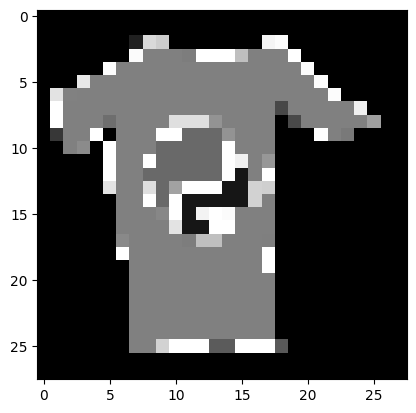

T-shirt/top


In [90]:
image_data = cv2.imread('tshirt.png', cv2.IMREAD_GRAYSCALE)
image_data = cv2.resize(image_data, (28, 28))

# Invert colors so that it matches training data format
image_data = 255 - image_data
plt.imshow(image_data, cmap='gray')
plt.show()

image_data = (image_data.reshape(1, -1).astype(np.float32) - 127.5) / 127.5

confidences = model.predict(image_data)

predictions = model.output_layer_activation.predictions(confidences)

prediction = fashion_mnist_labels[predictions[0]]

print(prediction)

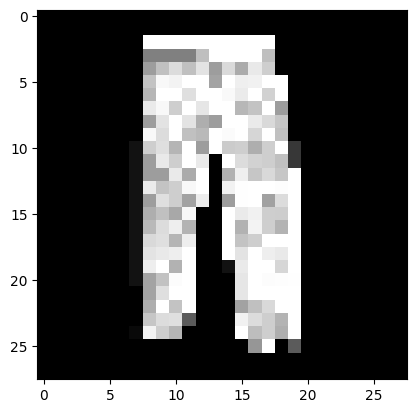

T-shirt/top


In [91]:
# Read image
image_data = cv2.imread('pants.png', cv2.IMREAD_GRAYSCALE)

# Resize and invert colors for it to match training data
image_data = cv2.resize(image_data, (28, 28))
image_data = 255 - image_data

plt.imshow(image_data, cmap='gray')
plt.show()

# Resizing into 2d array; samples x features so that model can use it
image_data = (image_data.reshape(1, -1).astype(np.float32) - 127.5) / 127.5

predictions = model.predict(image_data)

prediction = fashion_mnist_labels[0]

print(prediction)

# Incorrectly predicted, tried a couple variations of hyperparameters haven't found an optimal one yet, don't really care to spend the amount of time to find the best combination.